In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [235]:
fireball_time = 3.0 # Fireball cast time
scorch_time = 1.5
pyro_time = 6.0
ignite_tick_time = 2.0
ignite_refresh = 4.000000000000001 # Ignite debuff duration (make sure to get 2 ticks)
scorch_refresh = 30.0
scorch_duration_for_cast = 5.0
N_mage = 7 # Number of mages
crit_chances = np.ones(N_mage) * 0.4 # all mages have equal crit chance
spell_powers = np.ones(N_mage) * 700 # all mages have 500 sp
hit_chances = 0.83 + 0.06 + np.ones(N_mage) * 0.07 # all mages have 7% hit from gear
scorch_idx = crit_chances.argmin() # designate scorch bitch as lowest crit'er

In [236]:
def get_base_dmg(spellid=0, sp=0, rank=12):
    if spellid==0: #fireball
        if rank==11:
            base_dmg = np.random.uniform(561, 715) + 1*sp
        elif rank==12:
            base_dmg = np.random.uniform(596, 760) + 1*sp
        else:
            raise ValueError
    elif spellid==1: #pyro
        base_dmg = np.random.uniform(716, 890) + 1*sp
    elif spellid==2: #scorch
        base_dmg = np.random.uniform(237, 280) + 0.429*sp
    else:
        raise ValueError
    return base_dmg

In [237]:
def run_trial(verbose=False):
    time_till_cast = np.random.rand(N_mage) * 2.0
    casting = -np.ones(N_mage)
    number_casts_started = np.zeros(N_mage)
    damage_done = np.zeros(N_mage)
    ignite_owner = -1
    ignite_left = 0.0
    ignite_stacks = 0
    ignite_tick_dmg = 0.0
    time_till_tick = 0.0
    scorch_left = 0.0
    scorch_stacks = 0
    absolute_time = 0.0
    if verbose: print(("%.2f: initial casts at: "+", ".join(["%.2f"]*N_mage)) % (absolute_time, *time_till_cast))
    while absolute_time < 90.0:
        if ignite_stacks > 0 and time_till_tick < time_till_cast.min() and (scorch_stacks==0 or time_till_tick < scorch_left):
            if time_till_tick > ignite_left:
                absolute_time += ignite_left
                time_till_cast -= ignite_left
                scorch_left -= ignite_left
                ignite_left = 0.0
                ignite_stacks = 0
                ignite_tick_dmg = 0

            else:
                absolute_time += time_till_tick
                time_till_cast -= time_till_tick
                ignite_left -= time_till_tick
                scorch_left -= time_till_tick
                time_till_tick = ignite_tick_time
                damage_done[ignite_owner] += ignite_tick_dmg
                if verbose: print("%.2f: Ignite ticked for %d." % (absolute_time, ignite_tick_dmg))
        elif scorch_stacks > 0 and scorch_left < time_till_cast.min():
            absolute_time += scorch_left
            time_till_cast -= scorch_left
            time_till_tick -= scorch_left
            ignite_left -= scorch_left
            scorch_stacks = 0
            scorch_left = 0.0
            if verbose: print("%.2f: Scorch dropped." % absolute_time)
        else:
            #which mage
            mage_idx = time_till_cast.argmin()
            next_cast_time = time_till_cast[mage_idx]
            absolute_time += next_cast_time
            time_till_cast -= next_cast_time

            if ignite_stacks > 0:
                if next_cast_time > ignite_left: # ignite dropped
                    ignite_left = 0.0
                    ignite_stacks = 0
                    ignite_tick_dmg = 0
                    if verbose: print("%.2f: Ignite dropped." % absolute_time)
                else:
                    time_till_tick -= next_cast_time
                    ignite_left -= next_cast_time
            if scorch_stacks >0:
                if next_cast_time > scorch_left: # scorch dropped
                    scorch_left = 0.0
                    scorch_stacks = 0
                    if verbose: print("%.2f: Scorch dropped." % absolute_time)
                else:
                    scorch_left -= next_cast_time

            # damage, etc. from last spell
            if number_casts_started[mage_idx]>0: # at least one spell was cast
                if np.random.rand() < hit_chances[mage_idx]: # spell hit
                    dmg = get_base_dmg(casting[mage_idx], sp=spell_powers[mage_idx])
                    dmg *= 1.1 * 1.1 * (1 + 0.03 * scorch_stacks) # CoE, 10% fire dmg talent, and imp scorch
                    if np.random.rand() < crit_chances[mage_idx]: # spell crit
                        dmg *= 1.5
                        if ignite_stacks==0:
                            ignite_owner = mage_idx
                            time_till_tick = ignite_tick_time
                        if ignite_stacks<5:
                            ignite_stacks += 1
                            ignite_tick_dmg += dmg * 0.2 * 1.1 * (1 + 0.03 * scorch_stacks)
                        ignite_left = ignite_refresh
                        if verbose: print("%.2f: %d ignite stacks." % (absolute_time, ignite_stacks))
                    if verbose: print("%.2f: spell landed by %d" % (absolute_time, mage_idx))
                    damage_done[mage_idx] += dmg
                    if casting[mage_idx]==2: # was casting scorch
                        if np.random.rand() < hit_chances[mage_idx]: # imp scorch hit
                            scorch_stacks = min(scorch_stacks+1, 5)
                            scorch_left = scorch_refresh
                else:
                    if verbose: print("%.2f: spell missed by %d" % (absolute_time, mage_idx))

            # what spell is cast next
            if number_casts_started[mage_idx]==0: # cast initial scorch
                casting[mage_idx] = 2
                cast_time = scorch_time
            elif number_casts_started[mage_idx]==1: # cast initial pyro
                casting[mage_idx] = 1
                cast_time = pyro_time
            elif mage_idx==scorch_idx and (scorch_stacks<5 or scorch_left < scorch_duration_for_cast): # refresh scorch
                if verbose: print("%.2f: refreshing scorch @ %.2f duration, %d stacks" % (absolute_time, scorch_left, scorch_stacks))
                casting[mage_idx] = 2
                cast_time = scorch_time
            else:
                casting[mage_idx] = 0
                cast_time = fireball_time
            number_casts_started[mage_idx] += 1
            time_till_cast[mage_idx] = cast_time
            if verbose: print("%.2f: spell started by %d" % (absolute_time, mage_idx))
        if verbose: print("%.2f: ignitestacks:%d, left:%.2f, tilltick:%.2f, scorchstacks:%d, scorchleft:%.2f" % (absolute_time, ignite_stacks, ignite_left, time_till_tick, scorch_stacks, scorch_left))
            
    return damage_done

In [238]:
damage_dones = []
for i in range(10000):
    damage_dones.append(run_trial())
damage_dones = np.array(damage_dones)

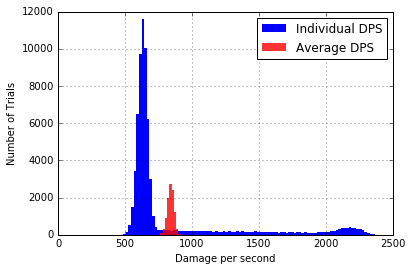

In [239]:
plt.hist(damage_dones.flatten()/90.0, bins=100, alpha=1, linewidth=0, label="Individual DPS");
plt.hist(damage_dones.mean(1)/90.0, bins=10, color='r', alpha=0.8, linewidth=0, label="Average DPS");
plt.xlabel("Damage per second")
plt.ylabel("Number of Trials")
plt.legend()
plt.grid()
#plt.savefig("N6_c40_h13_sp700.png", dpi=80, transparent=False)

In [240]:
(damage_dones/90.0).mean(1).mean(), (damage_dones/90.0).mean(1).std()/np.sqrt(damage_dones.shape[0])

(839.96881830380221, 0.23747357879255554)

In [ ]:
N=6, C=40, H=13, SP=700
861.88114189231396 +- 0.28874650290059154
N=6, C=40, H=13, SP=710
867.66759902417868 +- 0.29044973853282391
N=6, C=41, H=13, SP=700
866.40040260707906 +- 0.28527467493952607
N=6, C=40, H=14, SP=700
869.99720889843866 +- 0.28105572533203194
N=7, C=40, H=13, SP=700
839.96881830380221 +- 0.23747357879255554

In [107]:
n_hits_before_drop = []
time_before_drop = []
for i in range(10000):
    time_till_cast = init_time_till_cast(cast_distribution=2)
    cast_times = [] # times at which spells were cast
    crit_record = [] # boolean record of spell critical or hit
    IG_left = IG_refresh
    for i in range(10000):
        mage_idx = time_till_cast.argmin() # find which mage is casting next
        next_cast_time = time_till_cast[mage_idx]
        if next_cast_time > IG_left:
            #print("Ignite dropped after %d casts." % i)
            n_hits_before_drop.append(i)
            time_before_drop.append(cast_times[-1])
            break
        cast_times.append(next_cast_time + (cast_times[-1] if len(cast_times) else 0)) # record time at which cast is made
        time_till_cast -= next_cast_time # adjust all times till cast
        time_till_cast[mage_idx] = FB_cast # adjust current mage's time till cast
        if np.random.rand() < p_crit[mage_idx]: # this was a crit
            crit_record.append(True)
            IG_left =  IG_refresh       
        else: # this was not a crit
            crit_record.append(False)
            IG_left -= next_cast_time
    cast_times = np.array(cast_times)
    crit_record = np.array(crit_record)
    noncrit_record = np.logical_not(crit_record)
    

In [ ]:
def init_time_till_cast(cast_distribution=0):
    if cast_distribution == 0: # all casting together
        time_till_cast = np.zeros(N_mage)
    elif cast_distribution == 1: # uniform random initial cast
        latest_possible_start = 0.5
        time_till_cast = np.random.rand(N_mage) * latest_possible_start
    elif cast_distribution == 2: # uniform spread of casts
        time_till_cast = np.linspace(0, IG_refresh, N_mage)
    elif cast_distribution == 3: # normal distribution
        peak, width = 0.5, 1
        time_till_cast = np.random.normal(peak, width, 100000)
        time_till_cast = time_till_cast[time_till_cast>=0][:N_mage]
    elif cast_distribution == 4:
        time_till_cast = np.array([0, 0.1, 0.4, 0.8, 2.2, 3.8, 3.9])
        assert len(time_till_cast) == N_mage
    return time_till_cast

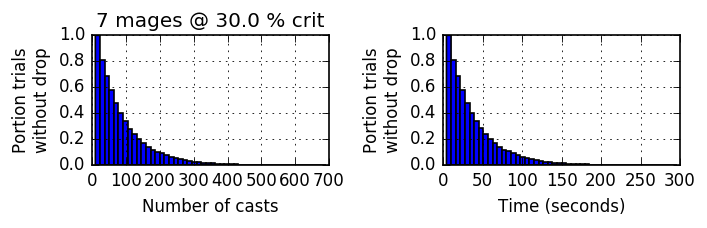

In [133]:
plt.figure(figsize=(6,2), dpi=120)
plt.subplot(1,2,1)
plt.hist(n_hits_before_drop, bins=50, cumulative=-1, normed=True);
plt.grid()
plt.xlabel("Number of casts")
plt.ylabel("Portion trials\nwithout drop")
plt.title("%d mages @ %.1f %% crit" % (N_mage, p_crit.mean()*100))
plt.subplot(1,2,2)
plt.hist(time_before_drop, bins=50, cumulative=-1, normed=True);
plt.grid()
plt.xlabel("Time (seconds)")
plt.ylabel("Portion trials\nwithout drop")
plt.tight_layout()
plt.savefig("7magus.jpg", transparent=False)

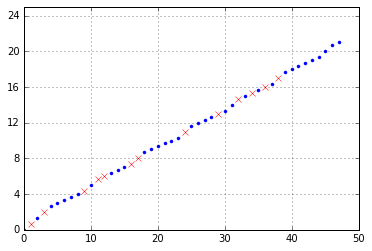

In [106]:
plt.plot(np.where(crit_record)[0], cast_times[crit_record], 'rx')
plt.plot(np.where(np.logical_not(crit_record))[0], cast_times[np.logical_not(crit_record)], 'b.')
plt.grid()
low, high = plt.ylim()
plt.yticks(np.arange(low, high, 4.0));

In [ ]:
np

In [91]:
for i in range(5):
    for j in range(3):
        if j==1:
            print(i,j)
            break

0 1
1 1
2 1
3 1
4 1
